## **Emotion Recognition Classification Task using the My Emotion Data Set**

The data consists of 48x48 pixel grayscale images of faces, each representing one of seven categories:

😡 0=Angry
🤢 1=Disgust
😨 2=Fear
😀 3=Happy
🥺 4=Sad
😲 5=Surprise
😐 6=Neutral.

**Overview**

Firstly, we explored the datatset, to get an understanding of missing values, class imbalances and the shape and size of the data. We began by creating a standard machine learning baseline model. Then, we created a Deep Nueral Network with three layers and expored various hyperparameters. Next, we considered the ResNet50 model and hypertuned this in an attempt to achieve optimum performance, and then briefly, we explored the more recent variation of this, ResNet50V2.

Our best model is ResNet50, using a learning rate scheduler and early stopping to achieve optimum performance. After hyperameter tuning, data augmentation and different configurations of the ResNet50 model, we managed to achieve 62% on the test set, which isn't a bad score, although, we did not manage to see the model converge to the level we hoped. We suspect ResNet50V2 may perform better if we had the time to look into additonal hyperparameter tuning, more or less layers, or other more complex or simple models. 


**Notebook Contents:**

✅   Import dataset and libraries

✅   Exploratory Data Analysis

✅   Methodology and pre-processing

  - Smote
  - Train and Validation, including Stratified Sampling
  - Data Augmentation

✅   Standard Machine Learning Model

✅   Deep Neural Network

✅ Transfer Learning; ResNet50

   - Model 0: basic, no augmentation
   - Model 1: Adam, 2 layers, augmentation, batch norm
   - Model 2: Adam, SDG, 2 layers augmentation, batch norm, dropout
   - Model 3: Adam, 3 layers, LR scheduler, batch norm
   - Apply best mode to train set
   - Make predictions on test set

✅ Transfer Learning; ResNet50V2

✅ Findings, Results and Suggestions for Improvements

The results tables are below, but more detail and explanation can be found at the end of our code. This is the mean val accuracy cross epochs, not neccessarily the best score at the end of one of the epochs.





```

```

**Results Table for model with full train and test**

| Model                |  Accuracy         | Standard Deviation |
|--------------------- |-------------------|--------------------|
| ResNet50 Model train |       62%         |        0.04        |
| Best Model Test Set  |         62%       |  Unrecovered        |
| Kaggle Score         |         62%       |        Unrecovered |

```

```


**Results Table for model with Train and Val**

| Model                | Val Mean Accuracy | Standard Deviation |
|--------------------- |-------------------|--------------------|
| Random Forest        |         43%       |   Unrecovered      |
| DNN Basic            |         33%       |        0.06        |
| DNN Random Search    |        36%        |        0.03        |
| ResNet50 Model 0     |       51%         |        0.07        |
| ResNet50 Model 1     |         52%       |        0.06        |
| ResNet50 Model 2     |         48%       |      0.06          |
| ResNet50 Model 3     |         47%       |         0.19       |
| ResNet50V2 Model 5   |         55%       |         0.01       |


```

✅ **Import Datasets and libraries**

1. Install Keras Tuner

In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


2. Import standard libraries

In [ ]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
from keras_tuner import Hyperband
from tensorflow.keras import layers, models
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Activation, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Add
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from collections import Counter
from tensorflow.keras.applications import ResNet50V2

# Sklearn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

3. Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/my_emotion_train.csv'
data = pd.read_csv(file_path)

In [ ]:
file_path = '/content/drive/My Drive/my_emotion_test.csv'
test_data = pd.read_csv(file_path)

In [ ]:
# data = pd.read_csv('my_emotion_train.csv')

✅ **Exploratory Data Analysis**

1. Shape of dataset

In [ ]:
print("Shape of the dataset:", data.shape)

print("First few rows of the dataset:")
print(data.head())

print("Missing values in the dataset:")
print(data.isnull().sum())

Shape of the dataset: (29000, 3)
First few rows of the dataset:
      id  emotion                                             pixels
0   9415        6  29 16 18 18 18 20 19 18 17 17 17 18 17 18 17 1...
1  19109        3  126 154 167 181 188 194 195 194 196 195 198 20...
2  21523        2  169 220 218 208 184 144 72 73 143 183 203 210 ...
3   2076        3  60 64 72 80 83 83 80 82 89 106 114 125 125 127...
4  13957        3  174 148 121 97 78 70 62 57 54 54 42 58 40 64 1...
Missing values in the dataset:
id         0
emotion    0
pixels     0
dtype: int64


2. Seperate the target and predictor

In [ ]:
X = data['pixels'].copy()
y = data['emotion'].copy()
id = data['id'].copy()

3. Create copy of the data for DNN

In [ ]:
X_dnn_copy = X.copy()
y_dnn_copy = y.copy()
id_dnn_copy = id.copy()

3. Create a copy of the data for ResNet50

In [ ]:
X_cnn_copy = X.copy()
y_cnn_copy = y.copy()
id_cnn_copy = id.copy()

4. Exploring class distributions

Emotion Distribution:
emotion
0    3993
1     440
2    4138
3    7289
4    4942
5    3206
6    4992
Name: count, dtype: int64


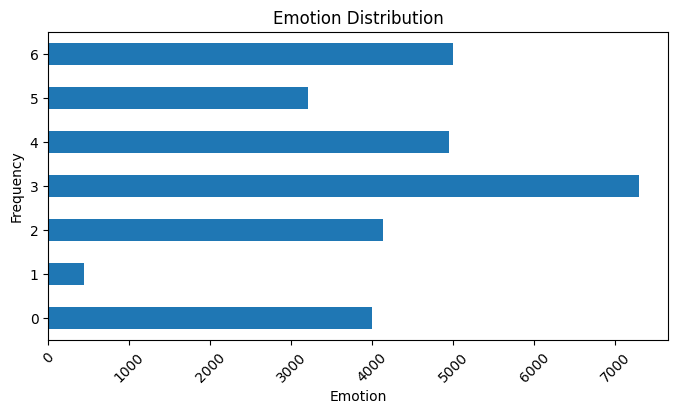

In [ ]:
class_distribution = y.value_counts().sort_index()
print("Emotion Distribution:")
print(class_distribution)

plt.figure(figsize=(8, 4))
class_distribution.plot(kind='barh')
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

5. Visualising our data

In [ ]:
data['pixels'] = data['pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(48, 48) / 255.0)
X = np.stack(data['pixels'].values).reshape(-1, 48, 48, 1)

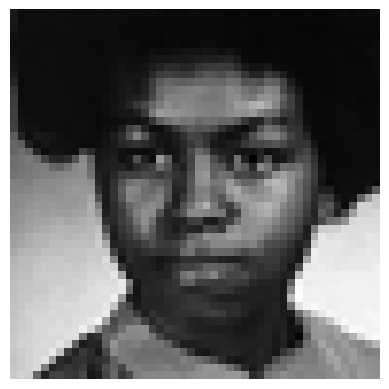

In [ ]:
image = data['pixels'].iloc[0]
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

✅ **Methodology and pre-processing**

The above exloratory analysis shows a class imbalance. How can we remedy this?

1. Stratification is a technique used to ensure that train and test datasets have the same proportions of class labels as the original dataset, but this wont deal with an undersample of one class. 

2. Increase class 1, such as through use of SMOTE, or, by assigning higher weights to class one when training the final model.

Next, we need to consider our target variable. We can either:

1. One hot encode the Labels as it is multi-class classification, as each instance can only belong to one class, or;

2. We can use sparse labels, which is more efficient for computational time, but we need to specify the correct loss function.

To start with, we will apply standard data transformations, with the awareness we will liely need differen transformations dependent on the model. This gives us a base understanding to start.

1. Check shape of data

In [ ]:
X.shape

(29000, 48, 48, 1)

2. Scale each channel individually and re-shape back to original shape (HUGO: We only have one channel as its not color images RGB, only black and white)

In [ ]:
scaler = StandardScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled_reshaped = scaler.fit_transform(X_reshaped)
X = X_scaled_reshaped.reshape(X.shape)

3. Split the data into train and vaidation set and stratify on y, to ensure evaluation fairness, so there is the same proportion of each class in the train and test set.

In [ ]:
val_size = 0.2
# Split the dataset into training and validation sets - stratify on y
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=42, stratify=y)

4. Data Augmentation. The dataset only has one feature per pixel. Techniques such as data augmentation may be beneficial, to increase the size of the dataset. Data augmentation artificially increases the size of the training set by generating many realistic variants of each training instance. This reduces overfitting, making this a regularization technique. Simply adding white noise will not help; the modifications should be learnable.

The below custom data augmentation transformations in this work have the following parameters:

1.   Random rotation
2.   Affine transformation
3.   Crop
4.   Horizontal flips

These functions can be used in the DNN below.

In [ ]:
def apply_affine_transformation(image, rotation=45):
    """Applies a rotation to the image."""
    return tf.keras.preprocessing.image.random_rotation(image, rg=rotation, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest')

def random_crop(image, crop_size=(20, 20)):
    """Randomly crops the image to a specified size."""
    if image.shape[0] < crop_size[0] or image.shape[1] < crop_size[1]:
        raise ValueError("Crop size must be smaller than image size")
    start_x = np.random.randint(0, image.shape[1] - crop_size[1] + 1)
    start_y = np.random.randint(0, image.shape[0] - crop_size[0] + 1)
    cropped_image = image[start_y:start_y+crop_size[0], start_x:start_x+crop_size[1], :]
    return tf.image.resize(cropped_image, [image.shape[0], image.shape[1]])

def custom_augmentation_generator(image_data_generator, X_data, y_data, batch_size):
    generator = image_data_generator.flow(X_data, y_data, batch_size=batch_size)
    while True:
        batch_x, batch_y = next(generator)
        for i in range(batch_x.shape[0]):
            if np.random.rand() < 0.5:
                batch_x[i] = apply_affine_transformation(batch_x[i])
            if np.random.rand() < 0.5:
                batch_x[i] = random_crop(batch_x[i])
        yield batch_x, batch_y


batch_size = 30

augmentation_params = dict(
    rotation_range=45,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_datagen = ImageDataGenerator(rescale=1./255, **augmentation_params)
validation_datagen = ImageDataGenerator(rescale=1./255)
custom_generator = custom_augmentation_generator(augmented_datagen, X_train, y_train, batch_size=20)
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=20)

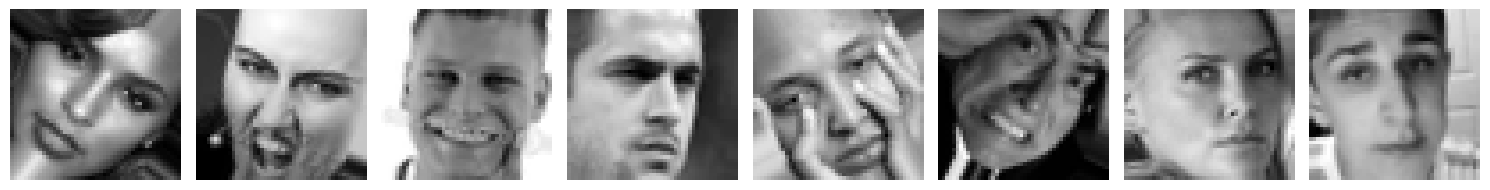

In [ ]:
augmented_images, _ = next(augmented_datagen.flow(X_train, y_train, batch_size=8))

plt.figure(figsize=(15, 3))
for i in range(len(augmented_images)):
    plt.subplot(1, 8, i+1)
    plt.imshow(augmented_images[i], cmap='gray' if augmented_images[i].shape[-1] == 1 else None)
    plt.axis('off')
plt.tight_layout()
plt.show()

✅**Machine Learning model**

Our first model will not use data augmentation. We will use the data as modelled above, and apply this to a Random Forest. Random Forests do not need Data Augmentation, due to the bootstrapping method which increases diversity. They are not sensitive to small transformations in the data like rotations or flips, unlike Convolutional Neural Networks (CNNs). The choice of a Random Forest as our baseline model is due to the models powerful ensemble learning method, combine multiple decision trees. They are also capable of multiclass classification. However, they are not the best models for image data, CNN's are preferred.

1. Re-shape the data back to 2D array

In [ ]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)

2. Create the model, 50 decision tree estimators

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)

4. Fit the model

In [ ]:
rf_clf.fit(X_train_reshaped, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

5. Predict on the validation set

In [ ]:
y_pred = rf_clf.predict(X_val_reshaped)

6. Print the accuracy scores

In [ ]:
print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
print("Classification report:")
print(classification_report(y_val, y_pred))

Accuracy: 0.43
Classification report:
              precision    recall  f1-score   support

           0       0.37      0.21      0.27       799
           1       1.00      0.27      0.43        88
           2       0.38      0.25      0.30       828
           3       0.44      0.74      0.55      1458
           4       0.33      0.33      0.33       988
           5       0.67      0.55      0.60       641
           6       0.42      0.34      0.38       998

    accuracy                           0.43      5800
   macro avg       0.52      0.38      0.41      5800
weighted avg       0.43      0.43      0.41      5800



Accuracy of 43% gives us a baseline of what to expect. Here we can see the problem with the class 1 imbalance. As class 1 has significantly fewer samples, the model may be careful about predicting an instance as class 1, leading to high precision but low recall.

✅ **Deep Neural Network**

First, we will try a default model which does not usually need much hyperparameter tuning. We will use a fresh copy of our data, to apply the correct processing.

**Default DNN configuration p.613 SkitLearn**

| Hyperparameter         | Default value                                 |
|------------------------|-----------------------------------------------|
| Kernel initializer     | He initialization                             |
| Activation function    | ReLU if shallow; Swish if deep                |
| Normalization          | one if shallow; batch norm if deep            |
| Regularization         | Early stopping; weight decay if needed        |
| Optimizer              | Nesterov accelerated gradients or AdamW       |
| Learning rate schedule | Performance scheduling or 1cycle              |

Following the table above, we have use He initialization and Elu as the optimiser. Elu was chosen over ReLu as it tends to converge faster and produce better results. We have also used a one cycle scheduler. We have chosen the number of units to start higher, and then decrease, with the idea being the network should learn to abstract the input data into increasingly concise and relevant representations as it moves toward the output layer. Due to the size of our data, we are starting with a reasonably large amount of units.

In [ ]:
X_dnn_copy
y_dnn_copy
id_dnn_copy

0         9415
1        19109
2        21523
3         2076
4        13957
         ...  
28995     7926
28996    21200
28997     1097
28998     4186
28999     8701
Name: id, Length: 29000, dtype: int64

1. Convert pixels from a string to 2D array with normalisation

In [ ]:
X_dnn_copy = np.array([np.fromstring(img, dtype=np.float32, sep=' ') for img in X_dnn_copy]) / 255.0
X_dnn_copy = X_dnn_copy.reshape(-1, 48, 48, 1)

2. Scale the data in case normalising it is not enough - if we had more time we would have considered whether scaling is neccessary. 

In [ ]:
num_samples, height, width, channels = X_dnn_copy.shape
X_dnn_reshaped = X_dnn_copy.reshape(num_samples, -1)

In [ ]:
scaler = StandardScaler()
X_dnn_scaled = scaler.fit_transform(X_dnn_reshaped)

3. Create a 4D array

In [ ]:
X_dnn_copy = X_dnn_scaled.reshape(num_samples, height, width, channels)

4. Train and val set

In [ ]:
val_size = 0.2
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=42, stratify=y)

5. Create a class for the augmented batch norm model and a One Cycle Scheduler to adjust the learning rate

---



In [ ]:
class AugmentedBatchNormModel_4(keras.Model):
    def __init__(self, input_shape, num_classes, activation="elu", dropout_rate=0.5, initializer='he_uniform', **kwargs):
        super().__init__(**kwargs)

        def get_initializer():
            if initializer == 'he_uniform':
                return keras.initializers.he_uniform()
            elif initializer == 'glorot_uniform':
                return keras.initializers.glorot_uniform()

        self.dense1 = keras.layers.Dense(500, use_bias=False, kernel_initializer=get_initializer())
        self.bn1 = keras.layers.BatchNormalization()
        self.act1 = keras.layers.Activation(activation)
        self.dropout1 = keras.layers.Dropout(dropout_rate)
        self.dense2 = keras.layers.Dense(300, use_bias=False, kernel_initializer=get_initializer())
        self.bn2 = keras.layers.BatchNormalization()
        self.act2 = keras.layers.Activation(activation)
        self.dropout2 = keras.layers.Dropout(dropout_rate)
        self.dense3 = keras.layers.Dense(200, use_bias=False, kernel_initializer=get_initializer())
        self.bn3 = keras.layers.BatchNormalization()
        self.act3 = keras.layers.Activation(activation)
        self.flatten = keras.layers.Flatten()
        self.output_layer = keras.layers.Dense(num_classes, activation='softmax', kernel_initializer=get_initializer())

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        x = self.bn2(x, training=training)
        x = self.act2(x)
        x = self.dropout2(x, training=training)
        x = self.flatten(x)
        return self.output_layer(x)

K = keras.backend

class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

input_shape = X_train.shape[1:]
num_classes = np.unique(y_train).size

model = AugmentedBatchNormModel_4(input_shape=input_shape, num_classes=num_classes, activation="elu", dropout_rate=0.5, initializer='he_uniform')
model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

batch_size = 65
epochs = 100

num_samples = X_train.shape[0]
total_iterations = (num_samples / batch_size) * epochs
max_rate = 0.005
start_rate = max_rate / 10
last_rate = start_rate / 1000
one_cycle_scheduler = OneCycleScheduler(iterations=total_iterations, max_rate=max_rate, start_rate=start_rate, last_iterations=total_iterations//10, last_rate=last_rate)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[one_cycle_scheduler, early_stopping])

Epoch 1/100
357/357 [==============================] - 14s 30ms/step - loss: 8.0057 - accuracy: 0.2360 - val_loss: 11.0649 - val_accuracy: 0.1681
Epoch 2/100
357/357 [==============================] - 10s 28ms/step - loss: 11.1824 - accuracy: 0.2546 - val_loss: 14.1953 - val_accuracy: 0.1779
Epoch 3/100
357/357 [==============================] - 10s 28ms/step - loss: 12.1490 - accuracy: 0.2682 - val_loss: 10.8601 - val_accuracy: 0.2266
Epoch 4/100
357/357 [==============================] - 10s 28ms/step - loss: 11.6631 - accuracy: 0.2822 - val_loss: 8.9867 - val_accuracy: 0.2866
Epoch 5/100
357/357 [==============================] - 10s 28ms/step - loss: 10.1873 - accuracy: 0.2849 - val_loss: 6.8031 - val_accuracy: 0.3229
Epoch 6/100
357/357 [==============================] - 10s 28ms/step - loss: 7.1604 - accuracy: 0.3057 - val_loss: 4.1739 - val_accuracy: 0.3424
Epoch 7/100
357/357 [==============================] - 10s 28ms/step - loss: 2.9930 - accuracy: 0.3295 - val_loss: 1.6380 -

In [ ]:
val_accuracies = history.history['val_accuracy']
mean_val_accuracy = np.mean(val_accuracies)
std_val_accuracy = np.std(val_accuracies)

print(f"Mean Validation Accuracy: {mean_val_accuracy:.2f}")
print(f"Standard Deviation in Validation Accuracy: {std_val_accuracy:.2f}")

Mean Validation Accuracy: 0.33
Standard Deviation in Validation Accuracy: 0.06


This model actually performed worse than the Random Forest, which was not to be expected. In hidsight, we may have tried Swish, as the model is considered a DNN, and this activation function may perform better on this task. However, ideally we will explore more hyperperameters, as we have not done so yet.

✅ **Deep Neural Network: random search**

The next model has the same architecture as the above, in terms of layers, however, we perform a random search to consider what hyperameters work best; a glorot_uniform initializer with relu or elu activation funtions, or a He initialisor with sigmoid or tahn. This model is not yet considering overfitting, as the aim here is to just get an idea of what activation and initialisers may perform best with this data set. However, Batch Normalisation may help with overfitting to the extent it behaves like a regualarizer.

The size of the neurons have been set considering the size of the dataset, and we can look at further tuning this with the next model. To reduce training computationality, the epochs for the random search have been reduced to 20, and the random search also to 20 configurations. Before we applied a Random Search, we did want to consider a Grid Search, but this took a lot of resources that we were likely to need later for the ResNet model.

We have also applied a learning rate scheduler's to optimize the training process by making the learning rate dynamic, adapting to the training process's state to balance the speed of convergence with the need to find a good generalizing solution.

1. Creating model class

In [ ]:
class BatchNormModel(keras.Model):
    def __init__(self, input_shape, num_classes, units1, units2, units3, activation="relu", dropout_rate=0.5, initializer='glorot_uniform', **kwargs):
        super().__init__(**kwargs)

        def get_initializer():
            if initializer == 'he_uniform':
                return keras.initializers.he_uniform()
            elif initializer == 'glorot_uniform':
                return keras.initializers.glorot_uniform()

        self.dense1 = keras.layers.Dense(units1, use_bias=False, kernel_initializer=get_initializer())
        self.bn1 = keras.layers.BatchNormalization()
        self.act1 = keras.layers.Activation(activation)
        self.dropout1 = keras.layers.Dropout(dropout_rate)
        self.dense2 = keras.layers.Dense(units2, use_bias=False, kernel_initializer=get_initializer())
        self.bn2 = keras.layers.BatchNormalization()
        self.act2 = keras.layers.Activation(activation)
        self.dropout2 = keras.layers.Dropout(dropout_rate)
        self.dense3 = keras.layers.Dense(units3, use_bias=False, kernel_initializer=get_initializer())
        self.bn3 = keras.layers.BatchNormalization()
        self.act3 = keras.layers.Activation(activation)
        self.flatten = keras.layers.Flatten()
        self.output_layer = keras.layers.Dense(num_classes, activation='softmax', kernel_initializer=get_initializer())

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        x = self.bn2(x, training=training)
        x = self.act2(x)
        x = self.dropout2(x, training=training)
        x = self.dense3(x)
        x = self.bn3(x, training=training)
        x = self.act3(x)
        x = self.flatten(x)
        return self.output_layer(x)


2. Learning Rate Scheduler

In [ ]:
class WarmUpExponentialDecaySchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, decay_rate, warmup_steps):
        super(WarmUpExponentialDecaySchedule, self).__init__()

        self.initial_learning_rate = tf.cast(initial_learning_rate, tf.float32)
        self.decay_steps = decay_steps
        self.decay_rate = tf.cast(decay_rate, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step_as_float = tf.cast(step, tf.float32)
        warmup_steps_as_float = tf.cast(self.warmup_steps, tf.float32)
        learning_rate = tf.cond(step < self.warmup_steps,
                                lambda: self.initial_learning_rate * step_as_float / warmup_steps_as_float,
                                lambda: self.initial_learning_rate * tf.math.pow(self.decay_rate,
                                                                                 (step_as_float - warmup_steps_as_float) / tf.cast(self.decay_steps, tf.float32)))
        return learning_rate

    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "decay_steps": self.decay_steps,
            "decay_rate": self.decay_rate,
            "warmup_steps": self.warmup_steps,
        }

3. Hyperameter tuning

In [ ]:
import random
seed_value = 123
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

input_shape = X_train.shape[1:]
num_classes = np.unique(y_train).size

def model_builder_random(hp):
    initializer_choice = hp.Choice('initializer', values=['he_uniform', 'glorot_uniform'])

    initial_learning_rate = hp.Choice('initial_learning_rate', values=[1e-2, 1e-3, 1e-4])
    warmup_epochs = hp.Int('warmup_epochs', 5, 10, step=5)
    decay_rate = hp.Float('decay_rate', 0.1, 1.0, sampling='log')
    total_epochs = 100

    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd'])
    if initializer_choice == 'he_uniform':
        activation_choice = hp.Choice('activation_he', values=['relu', 'elu'])
    elif initializer_choice == 'glorot_uniform':
        activation_choice = hp.Choice('activation_glorot', values=['sigmoid', 'tanh'])

    model = BatchNormModel(input_shape=(784,), num_classes=num_classes, units1=500, units2=300, units3=200, activation=activation_choice, initializer=initializer_choice)
    batch_size = 64
    steps_per_epoch = len(X_train) // batch_size
    lr_schedule = WarmUpExponentialDecaySchedule(initial_learning_rate, total_epochs * steps_per_epoch, decay_rate, warmup_epochs * steps_per_epoch)

    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


4. Random Search

In [ ]:
tuner = kt.RandomSearch(model_builder_random, objective='val_accuracy', max_trials=10, executions_per_trial=1, directory='keras_tuner_dir', project_name='BatchNorm_model_opt')
tuner.search(x=X_train, y=y_train, epochs=20, validation_data=(X_val, y_val))
model_best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 04m 11s]
val_accuracy: 0.348793089389801

Best val_accuracy So Far: 0.3808620572090149
Total elapsed time: 00h 42m 03s


5. Best model choice:

In [ ]:
initializer_choice = model_best_hps.get('initializer')

if initializer_choice == 'he_uniform':
    activation_choice_key = 'activation_he'
elif initializer_choice == 'glorot_uniform':
    activation_choice_key = 'activation_glorot'
else:
    activation_choice_key = 'activation'

print(f"""
The best optimizer is {model_best_hps.get('optimizer')}.
The best initializer is {initializer_choice}.
The best activation function is {model_best_hps.get(activation_choice_key)}.
""")


The best optimizer is sgd.
The best initializer is he_uniform.
The best activation function is elu.



6. Fit the best model, and consider the confusion matrix to check for class imbalance in the predictions.

In [ ]:
best_model = model_builder_random(model_best_hps)

optimizer_name = model_best_hps.get('optimizer')
learning_rate = model_best_hps.get('initial_learning_rate')

if optimizer_name == 'adam':
    optimizer = Adam(learning_rate=learning_rate)
elif optimizer_name == 'sgd':
    optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
else:
    raise ValueError("Unsupported optimizer")

best_model.compile(optimizer=optimizer,
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
725/725 [==============================] - 14s 17ms/step - loss: 7.2341 - accuracy: 0.2319 - val_loss: 8.1068 - val_accuracy: 0.2216
Epoch 2/20
725/725 [==============================] - 12s 17ms/step - loss: 7.0064 - accuracy: 0.2621 - val_loss: 4.1725 - val_accuracy: 0.3083
Epoch 3/20
725/725 [==============================] - 12s 17ms/step - loss: 4.3824 - accuracy: 0.2852 - val_loss: 2.2007 - val_accuracy: 0.3364
Epoch 4/20
725/725 [==============================] - 12s 17ms/step - loss: 1.8408 - accuracy: 0.3648 - val_loss: 1.6241 - val_accuracy: 0.3757
Epoch 5/20
725/725 [==============================] - 12s 17ms/step - loss: 1.5482 - accuracy: 0.4060 - val_loss: 1.6140 - val_accuracy: 0.3747
Epoch 6/20
725/725 [==============================] - 12s 17ms/step - loss: 1.5328 - accuracy: 0.4118 - val_loss: 1.6168 - val_accuracy: 0.3728
Epoch 7/20
725/725 [==============================] - 12s 17ms/step - loss: 1.5235 - accuracy: 0.4187 - val_loss: 1.6178 - val_accuracy:

In [ ]:
y_val_pred = best_model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

val_acc = history.history['val_accuracy']

mean_val_acc = np.mean(val_acc)
std_dev_val_acc = np.std(val_acc)

print(f"Mean Validation Accuracy: {mean_val_acc:.4f}")
print(f"Standard Deviation of Validation Accuracy: {std_dev_val_acc:.4f}")

182/182 [==============================] - 1s 6ms/step
Confusion Matrix:
 [[150   1  92 224 167  65 100]
 [  8  12  15  19  14   8  12]
 [102   1 151 183 165 129  97]
 [105   1  79 908 173  70 122]
 [113   1  86 271 314  48 155]
 [ 34   0  63  98  54 344  48]
 [112   2 100 236 171  79 298]]
Mean Validation Accuracy: 0.3620
Standard Deviation of Validation Accuracy: 0.0363


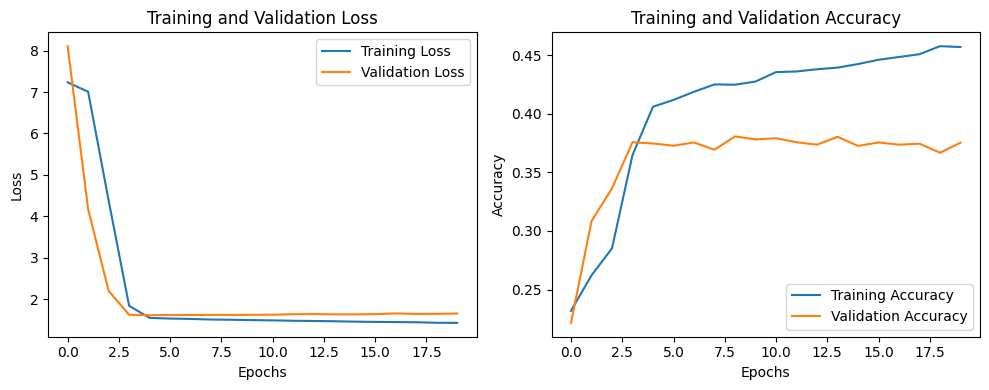

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_accuracy, label='Training Accuracy')
ax[1].plot(val_accuracy, label='Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

The Training and Validation Accuracy continuinly improve, for a few epochs, then the model appears to be overfitting, as it performs better on the training data than on the validation data. This is even with dropout, batch normalisation and data augmentation. Both training and validation loss decrease sharply and then plateau, suggesting that the model is learning and stabilizing. However the validation loss stops decreasing after about 5 epochs and remains constant, which might suggest that the model is not generalizing much after this point. The validation loss is still relatively high (around 1.6), and it's not decreasing significantly over time. This could indicate that the model is struggling to learn from the training data and generalize to the validation data. A high loss value, especially if it's not decreasing much over time, often indicates that the model is not fitting the data well. This could be due to several reasons: Model Architecture, Learning Rate, Data Issues, Optimization problem.


Still suprising to see the DNN did not perform as well as the Random Forest. One possibility may be due to the size of our data set. For image data, its not huge. DNNs usually require large amounts of data to learn effective representations of features, without overfitting. Random Forests may instead perform better on smaller datasets.

✅ **ResNet50**

ResNet50 is our chosen model due to its powerful performance on image data. Furthermore, we can utilise transfer learning with ImageNet weights. Training a deep model like ResNet50 from scratch requires a considerable amount of data, time, and resources. Transfer learning allows us to achieve high levels of accuracy with less data and in less time by fine-tuning a pretrained model.


*Roy, Manna and Bruzzone* suggest in their paper "Attention-Based Adaptive Spectral–Spatial Kernel ResNet for Hyperspectral Image Classification", the following hyperameters to explore when modelling a ResNet50. We will explore some of these as we tune our model:

*   Version	[’v1’, ‘v2’, ‘next’]
*   Batch Size	[32]
*   conv3_depth	[4, 8]
*   conv4_depth	[6, 23, 36]
*   Pooling	[’avg’, ‘max’]
*   Learning rate	[0.1, 0.01, 0.001]
*   Optimizer	[’adam’, ‘rmsprop’, ‘sgd’]


1. Pre-process data

We are now using our copied data. Firstly, we will process the data in the same way we did for the DNN model. However, we may need to modify our image data to replicate a 3 channel color image. We will also need to one hot encode the targets.

In [ ]:
X_cnn_copy
y_cnn_copy
id_cnn_copy

0         9415
1        19109
2        21523
3         2076
4        13957
         ...  
28995     7926
28996    21200
28997     1097
28998     4186
28999     8701
Name: id, Length: 29000, dtype: int64

2. Create copy to train best model on entire train set.

In [ ]:
X_cnn = X_cnn_copy.copy()
y_cnn = y_cnn_copy.copy()
id_cnn = id_cnn_copy.copy()

3. Normalise the values

In [ ]:
X_cnn_copy = np.array([np.fromstring(img, dtype=np.float32, sep=' ') for img in X_cnn_copy]) / 255.0
X_cnn_copy = X_cnn_copy.reshape(-1, 48, 48, 1)

4. Re-shape data to mimic a 3-channel color image

In [ ]:
X_cnn_copy = np.repeat(X_cnn_copy, 3, axis=-1)

In [ ]:
X_cnn_copy.shape

(29000, 48, 48, 3)

5. Scale and re-shape the data

In [ ]:
scaler = StandardScaler()
X_reshaped = X_cnn_copy.reshape(-1, 48, 48, 3)
X_scaled = scaler.fit_transform(X_reshaped.reshape(-1, 48*48*3)).reshape(-1, 48, 48, 3)

6. Train and validation

In [ ]:
val_size = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_cnn_copy, test_size=val_size, random_state=42, stratify=y)

7. One hot encode the labels

In [ ]:
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

8. Creating data augmentation to apply to our models. This is a simpler and cleaner way of augmenting the data than the code used for the DNN.

In [ ]:
data_augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    fill_mode='nearest'
)


✅ **Model 0: ResNet50, no augmentation, no regualarisation**

Firstly we import ResNet50, using the weights pre-trained and recovered from ImageNet. The model starts with all of the ResNet50 layers frozen.

1. Load model with imagenet weights and freeze all layers

In [ ]:
reg_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

for layer in reg_base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(reg_base_model.output)
x = Dense(128, activation='relu')(x)
n_classes = 7
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=reg_base_model.input, outputs=predictions)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

2. Check the number of layers

In [ ]:
num_layers = len(model.layers)
print("Number of layers in the model:", num_layers)

Number of layers in the model: 178


5. Train model for 3 epochs

In [ ]:
history = model.fit(X_train, y_train_one_hot, batch_size=32, steps_per_epoch=len(X_train) / 32, validation_data=(X_val, y_val_one_hot), epochs=3)

Epoch 1/3
725/725 [==============================] - 12s 10ms/step - loss: 1.7353 - accuracy: 0.3012 - val_loss: 1.6863 - val_accuracy: 0.3274
Epoch 2/3
725/725 [==============================] - 6s 8ms/step - loss: 1.6500 - accuracy: 0.3494 - val_loss: 1.6689 - val_accuracy: 0.3381
Epoch 3/3
725/725 [==============================] - 6s 8ms/step - loss: 1.6050 - accuracy: 0.3669 - val_loss: 1.6411 - val_accuracy: 0.3479


6. Unfreeze most layers (from layers 51)

In [ ]:
for layer in reg_base_model.layers[50:]:
    layer.trainable = True

7. Compile the model for longer (usually, you reduce the learning rate here, but we won't for now)

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train_one_hot, batch_size=32, steps_per_epoch=len(X_train) / 32, validation_data=(X_val, y_val_one_hot), epochs=30)

Epoch 1/30
725/725 [==============================] - 45s 31ms/step - loss: 1.5974 - accuracy: 0.3888 - val_loss: 24.2758 - val_accuracy: 0.3097
Epoch 2/30
725/725 [==============================] - 21s 29ms/step - loss: 1.4568 - accuracy: 0.4363 - val_loss: 2.3082 - val_accuracy: 0.2407
Epoch 3/30
725/725 [==============================] - 20s 28ms/step - loss: 1.4237 - accuracy: 0.4541 - val_loss: 2.0549 - val_accuracy: 0.3483
Epoch 4/30
725/725 [==============================] - 21s 29ms/step - loss: 1.3811 - accuracy: 0.4712 - val_loss: 1.3720 - val_accuracy: 0.4821
Epoch 5/30
725/725 [==============================] - 21s 29ms/step - loss: 1.2842 - accuracy: 0.5150 - val_loss: 1.3666 - val_accuracy: 0.4874
Epoch 6/30
725/725 [==============================] - 21s 29ms/step - loss: 1.2296 - accuracy: 0.5358 - val_loss: 1.3124 - val_accuracy: 0.5017
Epoch 7/30
725/725 [==============================] - 20s 28ms/step - loss: 1.1817 - accuracy: 0.5543 - val_loss: 1.3661 - val_accuracy

8. Results

In [ ]:
val_acc = history.history['val_accuracy']

mean_val_acc = np.mean(val_acc)
std_dev_val_acc = np.std(val_acc)

print(f"Mean Validation Accuracy: {mean_val_acc:.4f}")
print(f"Standard Deviation of Validation Accuracy: {std_dev_val_acc:.4f}")

Mean Validation Accuracy: 0.5165
Standard Deviation of Validation Accuracy: 0.0768


As expected, a lot of overfitting and no learning on the validation set.

✅ **Model 1: ResNet50**

We will build our next model. Due to the above overfitting, this model now incorporates batch normalisation, and we apply data augmentation. The model starts with all of the ResNet50 layers frozen.

1. Import model

In [ ]:
reg_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

2. Freeze all layers

In [ ]:
for layer in reg_base_model.layers:
    layer.trainable = False

3. Add own layers include batch norm, data augmentation to train. Train for 3 epochs.

In [ ]:
x = GlobalAveragePooling2D()(reg_base_model.output)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
n_classes = 7
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=reg_base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(data_augmentation.flow(X_train, y_train_one_hot, batch_size=32), steps_per_epoch=len(X_train) / 32, validation_data=(X_val, y_val_one_hot), epochs=3)

Epoch 1/3
725/725 [==============================] - 27s 30ms/step - loss: 1.8348 - accuracy: 0.2754 - val_loss: 1.7489 - val_accuracy: 0.3121
Epoch 2/3
725/725 [==============================] - 21s 29ms/step - loss: 1.7172 - accuracy: 0.3136 - val_loss: 1.7201 - val_accuracy: 0.3243
Epoch 3/3
725/725 [==============================] - 21s 29ms/step - loss: 1.6980 - accuracy: 0.3201 - val_loss: 1.7053 - val_accuracy: 0.3212


4. Unfreeze same layers as before

In [ ]:
for layer in reg_base_model.layers[50:]:
    layer.trainable = True

5. Recompile model and train for 60 epochs

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_augmentation.flow(X_train, y_train_one_hot, batch_size=32), steps_per_epoch=len(X_train) / 32, validation_data=(X_val, y_val_one_hot), epochs=60)

Epoch 1/60
725/725 [==============================] - 46s 35ms/step - loss: 1.6634 - accuracy: 0.3472 - val_loss: 1.7739 - val_accuracy: 0.3019
Epoch 2/60
725/725 [==============================] - 24s 32ms/step - loss: 1.5549 - accuracy: 0.3947 - val_loss: 1.7990 - val_accuracy: 0.3743
Epoch 3/60
725/725 [==============================] - 24s 32ms/step - loss: 1.4934 - accuracy: 0.4237 - val_loss: 1.5332 - val_accuracy: 0.4276
Epoch 4/60
725/725 [==============================] - 24s 33ms/step - loss: 1.4732 - accuracy: 0.4338 - val_loss: 8.2926 - val_accuracy: 0.3453
Epoch 5/60
725/725 [==============================] - 24s 33ms/step - loss: 1.4764 - accuracy: 0.4315 - val_loss: 1.4275 - val_accuracy: 0.4476
Epoch 6/60
725/725 [==============================] - 24s 33ms/step - loss: 1.4430 - accuracy: 0.4429 - val_loss: 1.6045 - val_accuracy: 0.4755
Epoch 7/60
725/725 [==============================] - 24s 33ms/step - loss: 1.4209 - accuracy: 0.4538 - val_loss: 15.4423 - val_accuracy

6. Results

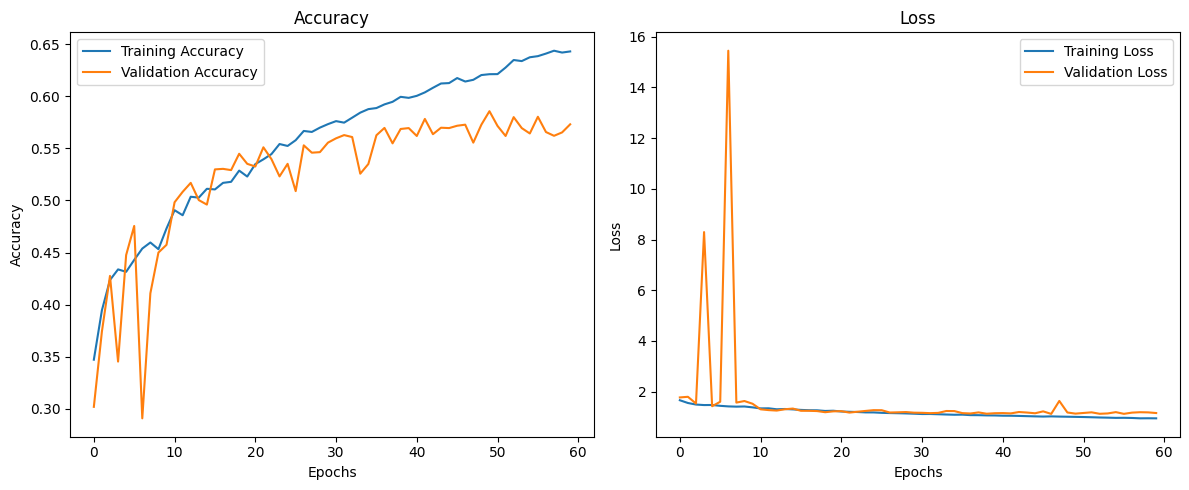

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
val_predictions = model.predict(X_val)
val_predictions_indices = np.argmax(val_predictions, axis=1)

cls_report = classification_report(np.argmax(y_val_one_hot, axis=1), val_predictions_indices)
print("Classification Report:\n", cls_report)

182/182 [==============================] - 2s 6ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.51      0.49       799
           1       0.50      0.33      0.40        88
           2       0.41      0.39      0.40       828
           3       0.82      0.77      0.80      1458
           4       0.48      0.40      0.44       988
           5       0.68      0.72      0.70       641
           6       0.48      0.59      0.53       998

    accuracy                           0.57      5800
   macro avg       0.55      0.53      0.53      5800
weighted avg       0.58      0.57      0.57      5800



In [ ]:
val_acc = history.history['val_accuracy']
mean_val_acc = np.mean(val_acc)
std_dev_val_acc = np.std(val_acc)

print(f"Mean Validation Accuracy: {mean_val_acc:.4f}")
print(f"Standard Deviation of Validation Accuracy: {std_dev_val_acc:.4f}")

Mean Validation Accuracy: 0.5254
Standard Deviation of Validation Accuracy: 0.0660


✅ **Model 2: ResNet50**

There are problems with the above model. The loss is decreasing on the training set, but not on the validation set, it is jumping around. The accuracy is slowly increasing on both. However, after epoch 3, the loss did not decrease, and accuracy did not increase, at the same rate on the validation set as it did on the training set.

To improve the model, we can consider a model with SGD and a lower learning rate once more layers are frozen. We may then change the batch size to 64, and train the model for longer. This may help to balance out the training time whilst also allowing the model to converge. We will also try adding in dropout as we are training the model for longer, and would like to ensure no overfitting.

The choice of SGD is due to the fact SGD can sometimes reach better final performance than Adam can, although it takes longer to converge. We may also see a smoother descent toward convergence, as opposed to the jumping around we have seen whilst using Adam.  

1. Load model, add in dropout. Start with Adam for 3 epochs.

In [ ]:
model_base = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

for layer in model_base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(model_base.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
n_classes = 7
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=model_base.input, outputs=predictions)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(data_augmentation.flow(X_train, y_train_one_hot, batch_size=32), steps_per_epoch=len(X_train) / 32, validation_data=(X_val, y_val_one_hot), epochs=3)

Epoch 1/3
725/725 [==============================] - 27s 30ms/step - loss: 2.1635 - accuracy: 0.2177 - val_loss: 1.7520 - val_accuracy: 0.3019
Epoch 2/3
725/725 [==============================] - 21s 29ms/step - loss: 1.7996 - accuracy: 0.2668 - val_loss: 1.7273 - val_accuracy: 0.3091
Epoch 3/3
725/725 [==============================] - 21s 29ms/step - loss: 1.7649 - accuracy: 0.2802 - val_loss: 1.7183 - val_accuracy: 0.3162


2. Unfreeze more of the layers this time, lower learning rate and switch to SGD, then recompile model.

In [ ]:
for layer in model_base.layers[20:]:
    layer.trainable = True

optimizer = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_augmentation.flow(X_train, y_train_one_hot, batch_size=64), steps_per_epoch=len(X_train) / 64, validation_data=(X_val, y_val_one_hot), epochs=60)

Epoch 1/60
362/362 [==============================] - 39s 61ms/step - loss: 1.8318 - accuracy: 0.2359 - val_loss: 1.7809 - val_accuracy: 0.2684
Epoch 2/60
362/362 [==============================] - 21s 58ms/step - loss: 1.7971 - accuracy: 0.2547 - val_loss: 1.7436 - val_accuracy: 0.2940
Epoch 3/60
362/362 [==============================] - 21s 57ms/step - loss: 1.7592 - accuracy: 0.2812 - val_loss: 1.7099 - val_accuracy: 0.3166
Epoch 4/60
362/362 [==============================] - 20s 56ms/step - loss: 1.7153 - accuracy: 0.3053 - val_loss: 1.6469 - val_accuracy: 0.3507
Epoch 5/60
362/362 [==============================] - 20s 55ms/step - loss: 1.6723 - accuracy: 0.3290 - val_loss: 1.5985 - val_accuracy: 0.3776
Epoch 6/60
362/362 [==============================] - 20s 55ms/step - loss: 1.6406 - accuracy: 0.3453 - val_loss: 1.5655 - val_accuracy: 0.3966
Epoch 7/60
362/362 [==============================] - 21s 57ms/step - loss: 1.6189 - accuracy: 0.3618 - val_loss: 1.5441 - val_accuracy:

3. Results

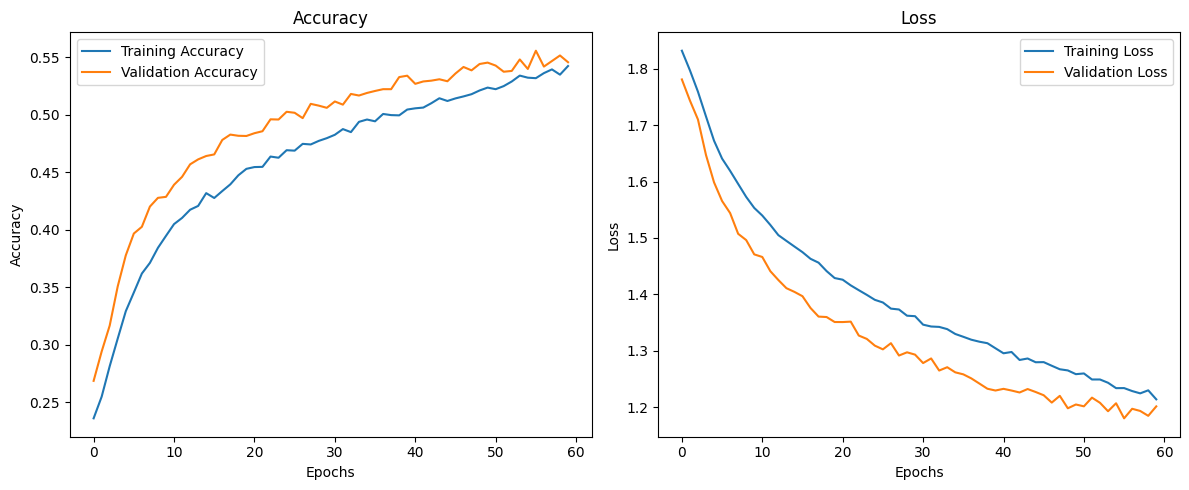

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
val_predictions = model.predict(X_val)
val_predictions_indices = np.argmax(val_predictions, axis=1)

cls_report = classification_report(np.argmax(y_val_one_hot, axis=1), val_predictions_indices)
print("Classification Report:\n", cls_report)

182/182 [==============================] - 2s 6ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.36      0.40       799
           1       0.69      0.10      0.18        88
           2       0.41      0.24      0.30       828
           3       0.84      0.72      0.78      1458
           4       0.42      0.54      0.47       988
           5       0.71      0.68      0.70       641
           6       0.42      0.65      0.51       998

    accuracy                           0.55      5800
   macro avg       0.57      0.47      0.48      5800
weighted avg       0.57      0.55      0.54      5800



In [ ]:
val_acc = history.history['val_accuracy']
mean_val_acc = np.mean(val_acc)
std_dev_val_acc = np.std(val_acc)

print(f"Mean Validation Accuracy: {mean_val_acc:.4f}")
print(f"Standard Deviation of Validation Accuracy: {std_dev_val_acc:.4f}")

Mean Validation Accuracy: 0.4887
Standard Deviation of Validation Accuracy: 0.0644


Dropout appears to have prevented overfitting to a degree, although there is still overfitting, and the learning rate is steadily decreasing which is likely due to the use of SGD with a lower learning rate on the opitimiser and learning rate used for the model with all the base model layers frozen. We would like the loss to converge, as at the moment it looks like the model can continue to learn. The model taking longer to learn is common when using SDG as the optimiser.

Its tempting to run the below code, but it will take a lot of computational resources....

4. Run again, for longer, and unfreeze more layers

In [ ]:
# for layer in model_base.layers[5:]:
   # layer.trainable = True

# optimizer = SGD(learning_rate=0.0001, momentum=0.9)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(data_augmentation.flow(X_train, y_train_one_hot, batch_size=64), steps_per_epoch=len(X_train) / 64, validation_data=(X_val, y_val_one_hot), epochs=80)


✅ **Model 3: ResNet50**

This model now includes a learning rate scheduer, and uses Adam both before and after freezing model layers. This model also includes an extra layer. This model was initially tried without dropout. Dropout was then included to reduce some overfitting, but the model performed far worse, so dropout was removed again.

We chose this model as considering the two models above, the model using Adam did seem to be learning more quickly whereas SDG was rather slow. A learning rate scheduler, alongside data augmentation and batch normalisation, may help the model to learn quickly and converge. Too large a learning rate can cause the model to converge too quickly to a suboptimal solution, or even diverge, while too small a learning rate can make the training process unnecessarily slow and prone to getting stuck in local minima. We saw the latter issue above. A learning rate scheduler helps to navigate this issue.


1. Load model, add another layer, remove dropout.

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(100, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(150, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                         

2. Compile model, train for 3 epochs.

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_augmentation.flow(X_train, y_train_one_hot, batch_size=32), steps_per_epoch=len(X_train) / 32, validation_data=(X_val, y_val_one_hot), epochs=3)

Epoch 1/3
725/725 [==============================] - 33s 34ms/step - loss: 1.7936 - accuracy: 0.2715 - val_loss: 1.7360 - val_accuracy: 0.3105
Epoch 2/3
725/725 [==============================] - 23s 32ms/step - loss: 1.7235 - accuracy: 0.3016 - val_loss: 1.7251 - val_accuracy: 0.3155
Epoch 3/3
725/725 [==============================] - 22s 31ms/step - loss: 1.6982 - accuracy: 0.3190 - val_loss: 1.6961 - val_accuracy: 0.3241


3. Leave almost all of the layers unfrozen, except a few.

In [ ]:
N = 168
for layer in base_model.layers[-N:]:
    layer.trainable = True

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 batch_normalization_1 (Bat  (None, 100)               4

4. Compile model again with LR scheduler, and early stopping.

In [ ]:
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)

callbacks_list = [early_stopping]

optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    data_augmentation.flow(X_train, y_train_one_hot, batch_size=32),
    steps_per_epoch=len(X_train) / 32,
    validation_data=(X_val, y_val_one_hot),
    epochs=60,
    callbacks=callbacks_list)

Epoch 1/60
725/725 [==============================] - 72s 50ms/step - loss: 1.4986 - accuracy: 0.4214 - val_loss: 2.2699 - val_accuracy: 0.1378
Epoch 2/60
725/725 [==============================] - 36s 49ms/step - loss: 1.3330 - accuracy: 0.4954 - val_loss: 2.6632 - val_accuracy: 0.1319
Epoch 3/60
725/725 [==============================] - 37s 51ms/step - loss: 1.2477 - accuracy: 0.5281 - val_loss: 2.7735 - val_accuracy: 0.1114
Epoch 4/60
725/725 [==============================] - 38s 52ms/step - loss: 1.1829 - accuracy: 0.5550 - val_loss: 2.2096 - val_accuracy: 0.1836
Epoch 5/60
725/725 [==============================] - 36s 50ms/step - loss: 1.1345 - accuracy: 0.5754 - val_loss: 4.6733 - val_accuracy: 0.1428
Epoch 6/60
725/725 [==============================] - 37s 51ms/step - loss: 1.0893 - accuracy: 0.5898 - val_loss: 2.2314 - val_accuracy: 0.2379
Epoch 7/60
725/725 [==============================] - 37s 50ms/step - loss: 1.0502 - accuracy: 0.6070 - val_loss: 2.9431 - val_accuracy:

5. Results

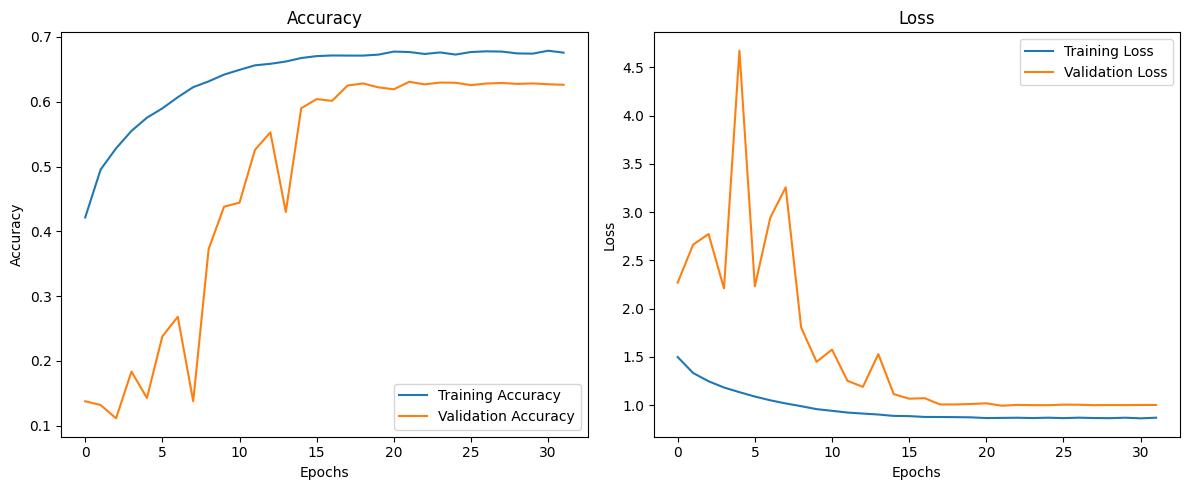

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
val_predictions = model.predict(X_val)
val_predictions_indices = np.argmax(val_predictions, axis=1)
cls_report = classification_report(np.argmax(y_val_one_hot, axis=1), val_predictions_indices)
print("Classification Report:\n", cls_report)

182/182 [==============================] - 2s 7ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.54      0.52       799
           1       0.45      0.41      0.43        88
           2       0.53      0.36      0.43       828
           3       0.86      0.84      0.85      1458
           4       0.52      0.54      0.53       988
           5       0.75      0.74      0.74       641
           6       0.54      0.67      0.60       998

    accuracy                           0.63      5800
   macro avg       0.59      0.58      0.59      5800
weighted avg       0.63      0.63      0.63      5800



In [ ]:
val_acc = history.history['val_accuracy']
mean_val_acc = np.mean(val_acc)
std_dev_val_acc = np.std(val_acc)

print(f"Mean Validation Accuracy: {mean_val_acc:.4f}")
print(f"Standard Deviation of Validation Accuracy: {std_dev_val_acc:.4f}")

Mean Validation Accuracy: 0.4786
Standard Deviation of Validation Accuracy: 0.1926


This was the best model so far. There is not too much overfitting. However, the downside is the model looks like it could continue to learn, yet it has stopped learning on the validation set. The model may also just be too complex for our data, which is simpler than ImageNet.

✅ **Apply model to the entire train set**

1. Normalise train data

In [ ]:
X_cnn = np.array([np.fromstring(img, dtype=np.float32, sep=' ') for img in X_cnn]) / 255.0
X_cnn = X_cnn.reshape(-1, 48, 48, 1)

2. Mimic 3-scale colour image

In [ ]:
X_cnn = np.repeat(X_cnn, 3, axis=-1)

3. Scale data

In [ ]:
scaler = StandardScaler()
X_reshaped = X_cnn.reshape(-1, 48, 48, 3)
X_scaled = scaler.fit_transform(X_reshaped.reshape(-1, 48*48*3)).reshape(-1, 48, 48, 3)

4. One Hot encode Y

In [ ]:
y_cnn_one_hot = to_categorical(y_cnn)

5. Create model

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(100, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(150, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_3 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 100)               204900    
                                                                 
 batch_normalization_4 (Bat  (None, 100)              

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_augmentation.flow(X_scaled, y_cnn_one_hot, batch_size=32),
                    steps_per_epoch=len(X_scaled) / 32,
                    epochs=3)

Epoch 1/3
906/906 [==============================] - 31s 29ms/step - loss: 1.7788 - accuracy: 0.2784
Epoch 2/3
906/906 [==============================] - 26s 29ms/step - loss: 1.7128 - accuracy: 0.3067
Epoch 3/3
906/906 [==============================] - 26s 29ms/step - loss: 1.6902 - accuracy: 0.3224


In [ ]:
N = 168
for layer in base_model.layers[-N:]:
    layer.trainable = True


In [ ]:
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

early_stopping = EarlyStopping(
    monitor='loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)

callbacks_list = [early_stopping]

optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    data_augmentation.flow(X_scaled, y_cnn_one_hot, batch_size=32),
    steps_per_epoch=len(X_scaled) / 32,
    epochs=60,
    callbacks=callbacks_list)

Epoch 1/60
906/906 [==============================] - 75s 48ms/step - loss: 1.3599 - accuracy: 0.4827
Epoch 2/60
906/906 [==============================] - 43s 48ms/step - loss: 1.2441 - accuracy: 0.5296
Epoch 3/60
906/906 [==============================] - 43s 47ms/step - loss: 1.1743 - accuracy: 0.5522
Epoch 4/60
906/906 [==============================] - 43s 47ms/step - loss: 1.1255 - accuracy: 0.5766
Epoch 5/60
906/906 [==============================] - 43s 47ms/step - loss: 1.0826 - accuracy: 0.5929
Epoch 6/60
906/906 [==============================] - 43s 47ms/step - loss: 1.0460 - accuracy: 0.6050
Epoch 7/60
906/906 [==============================] - 43s 47ms/step - loss: 1.0215 - accuracy: 0.6162
Epoch 8/60
906/906 [==============================] - 43s 47ms/step - loss: 1.0084 - accuracy: 0.6205
Epoch 9/60
906/906 [==============================] - 43s 47ms/step - loss: 0.9957 - accuracy: 0.6229
Epoch 10/60
906/906 [==============================] - 43s 48ms/step - loss: 0.976

In [ ]:
y_pred = model.predict(X_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_cnn_one_hot, axis=1)

report = classification_report(y_true_classes, y_pred_classes)
print(report)

907/907 [==============================] - 7s 8ms/step
              precision    recall  f1-score   support

           0       0.57      0.60      0.59      3993
           1       0.60      0.37      0.45       440
           2       0.56      0.36      0.43      4138
           3       0.86      0.87      0.87      7289
           4       0.57      0.48      0.52      4942
           5       0.74      0.68      0.71      3206
           6       0.52      0.78      0.63      4992

    accuracy                           0.65     29000
   macro avg       0.63      0.59      0.60     29000
weighted avg       0.65      0.65      0.64     29000



In [ ]:
training_accuracies = history.history['accuracy']
mean_training_accuracy = np.mean(training_accuracies)
std_dev_training_accuracy = np.std(training_accuracies)

print(f"Mean Training Accuracy: {mean_training_accuracy:.2f}")
print(f"Standard Deviation of Training Accuracy: {std_dev_training_accuracy:.2f}")

Mean Training Accuracy: 0.62
Standard Deviation of Training Accuracy: 0.04


✅ **Apply the model to the test data**

1. Seperate X from id

In [ ]:
X = test_data['pixels'].copy()
id = test_data['id'].copy()

2. Normalise and re-shape

In [ ]:
X_test = np.array([np.fromstring(img, dtype=np.float32, sep=' ') for img in X]) / 255.0
X_test = X_test.reshape(-1, 48, 48, 1)

3. Mimic 3-channe color image

In [ ]:
X_test = np.repeat(X_test, 3, axis=-1)

4. Scale the data

In [ ]:
scaler = StandardScaler()
X_reshaped = X_test.reshape(-1, 48, 48, 3)
X_test_scaled = scaler.fit_transform(X_reshaped.reshape(-1, 48*48*3)).reshape(-1, 48, 48, 3)

5. Make predictions on the test data

In [ ]:
predictions = model.predict(X_test_scaled)
predicted_classes = np.argmax(predictions, axis=1)
results = pd.DataFrame({'id': id, 'emotion': predicted_classes})

216/216 [==============================] - 2s 9ms/step


6. Save results

In [ ]:
results.to_csv('/content/drive/My Drive/predicted_emotions_final.csv', index=False)

✅ **ResNet50V2 - with Pre-activation**

He et al proposed a pre-activation structure to pre-activate the BN and ReLU to further improve the network performance. This worked very well on ImageNet, so we wanted to try it here. The first model shows no improvement, but we have not cosidered any hyperameter tuning, as we do not have more time.

In [ ]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(100, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(150, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_6 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 100)               204900    
                                                                 
 batch_normalization_7 (Bat  (None, 100)              

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_augmentation.flow(X_train, y_train_one_hot, batch_size=32), steps_per_epoch=len(X_train) / 32, validation_data=(X_val, y_val_one_hot), epochs=3)

Epoch 1/3
725/725 [==============================] - 29s 33ms/step - loss: 1.7485 - accuracy: 0.2929 - val_loss: 1.6691 - val_accuracy: 0.3388
Epoch 2/3
725/725 [==============================] - 22s 31ms/step - loss: 1.6763 - accuracy: 0.3249 - val_loss: 1.6499 - val_accuracy: 0.3374
Epoch 3/3
725/725 [==============================] - 22s 30ms/step - loss: 1.6523 - accuracy: 0.3344 - val_loss: 1.6216 - val_accuracy: 0.3552


In [ ]:
N = 150
for layer in base_model.layers[-N:]:
    layer.trainable = True

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_6 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 100)               204900    
                                                                 
 batch_normalization_7 (Bat  (None, 100)              

In [51]:
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)

callbacks_list = [early_stopping]

optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_augmentation.flow(X_train, y_train_one_hot, batch_size=32), steps_per_epoch=len(X_train) / 32, validation_data=(X_val, y_val_one_hot), epochs=60)

Epoch 1/60
725/725 [==============================] - 52s 41ms/step - loss: 1.3756 - accuracy: 0.4699 - val_loss: 1.8310 - val_accuracy: 0.4848
Epoch 2/60
725/725 [==============================] - 28s 39ms/step - loss: 1.3297 - accuracy: 0.4857 - val_loss: 1.5802 - val_accuracy: 0.4974
Epoch 3/60
725/725 [==============================] - 28s 39ms/step - loss: 1.3052 - accuracy: 0.4928 - val_loss: 4.9329 - val_accuracy: 0.5303
Epoch 4/60
725/725 [==============================] - 28s 39ms/step - loss: 1.2747 - accuracy: 0.5071 - val_loss: 8.3910 - val_accuracy: 0.5252
Epoch 5/60
725/725 [==============================] - 28s 39ms/step - loss: 1.2461 - accuracy: 0.5139 - val_loss: 3.4255 - val_accuracy: 0.5260
Epoch 6/60
725/725 [==============================] - 29s 39ms/step - loss: 1.2333 - accuracy: 0.5259 - val_loss: 5.0869 - val_accuracy: 0.5360
Epoch 7/60
725/725 [==============================] - 28s 39ms/step - loss: 1.2194 - accuracy: 0.5300 - val_loss: 1.4214 - val_accuracy:

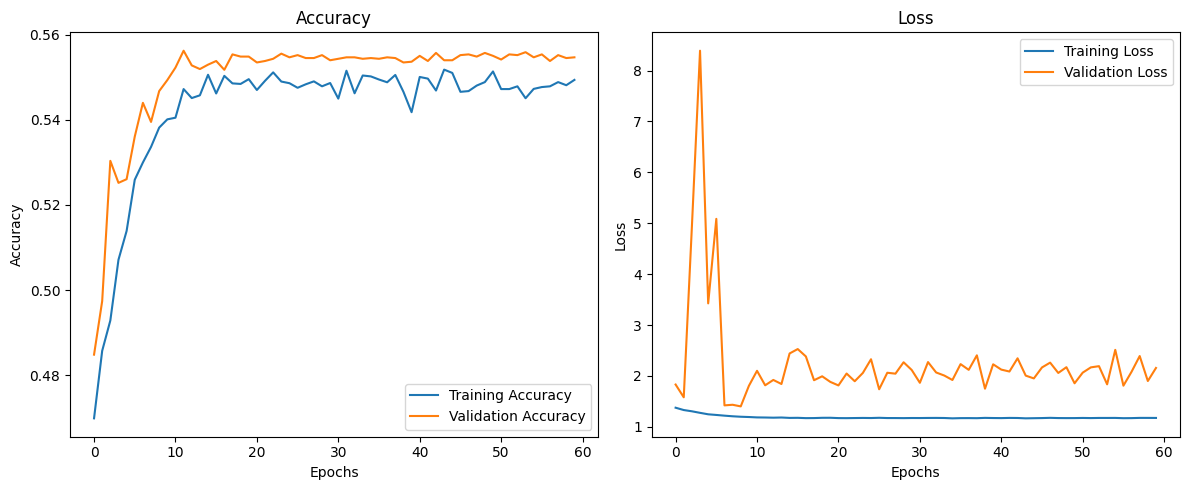

In [52]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
val_acc = history.history['val_accuracy']

mean_val_acc = np.mean(val_acc)
std_dev_val_acc = np.std(val_acc)

print(f"Mean Validation Accuracy: {mean_val_acc:.4f}")
print(f"Standard Deviation of Validation Accuracy: {std_dev_val_acc:.4f}")

Mean Validation Accuracy: 0.5500
Standard Deviation of Validation Accuracy: 0.0129


**Learnings, Results and Improvements**

Firstly, we will consider our models and their accuracys in the table below.
Our best model was ResNet50, model 3, with almost all layers unfrozen, the Learning Rate Scheduler, Batch Normalisation and Adam as the optimiser both before and after freezing layers. On the test set, this achieved 62%. This was our best model due to the optimiser and LRS allowing the model to converge (to an extent) and also, batch normalisation and data augmentation prevented overfitting.

The mean val accuracy shows lower on our best model, but this is due to less epochs in total having a high accuracy, as then seen on the full train and test set.


```

```


**Results Table for model with Train and Val**

| Model                | Val Mean Accuracy | Standard Deviation |
|--------------------- |-------------------|--------------------|
| Random Forest        |         43%       |   Unrecovered      |
| DNN Basic            |         33%       |        0.06        |
| DNN Random Search    |        36%        |        0.03        |
| ResNet50 Model 0     |       51%         |        0.07        |
| ResNet50 Model 1     |         52%       |        0.06        |
| ResNet50 Model 2     |         48%       |      0.06          |
| ResNet50 Model 3     |         47%       |         0.19       |
| ResNet50V2 Model 5   |         55%       |         0.01       |


```

```

**Results Table for model with full train and test**

| Model                |  Accuracy         | Standard Deviation |
|--------------------- |-------------------|--------------------|
| ResNet50 Model train |       62%         |        0.04        |
| Best Model Test Set  |         62%       |  Unrecovered        |
| Kaggle Score         |         62%       |        Unrecovered |

```

```


**How can we improve the model?**

There are many things we may have done:

1.   The models are struggling to predict Class 1, or predicting the class with more instances a lot higher, so ideally, we would have used SMOTE.This was an issue we saw repeated throughout the analysis, so in hindsight this shouldnt have been overlooked. Although interestingly our best model didn't seem to have problems predicting class 1. 

2.   We could have tried many more model parameters, such as more layers, and different units. However, it may be the case that the ResNet50 model is actually too complicated for our dataset which may be why it was struggling with the validation set. Perhaps a simpler version of ResNet may have been better.

**What did we learn?**

1. As expected, ResNet50 performs best on our dataset than DNN'S and Random Forests. Data Augmentation and batch normalisation improve model performance and prevent overfitting with the ResNet50 model.

2. For the DNN, a Random Search is useful, especially when creating a class to specify the hyperparameters known to work well with one another. However, a grid search may be better, but computationally expensive.

3. For ResNet50, Adam is the best optimiser, for ensuring the model learns quickly, however it leads to a rockier learning rate than the smooth downward slope we saw when using the SGD optimiser. We didn't really give the model with SGD the length of time to train that it deserved - it may have continued to learn. Implementing a Learning Rate Scheduler with Adam led to the best outcome,as it prevented the model getting stuck in local minima, which it appeared to be doing previously.

4. Our final model stopped learning at a certain point, which was slightly frustrating. But overall, our score was not too bad.

5. Running these models takes up a huge amount of computational time and resources. Being picky about the hyperameters helps, alongside knowledge of what will work well with this kind of dataset.
